In [ ]:
!pip install keras-tuner
!pip install convokit


In [ ]:
#lo que tenemos que hacer es importar el corpues usar el embedding para que nos devuelva las palabras en formato numerico para el modelo,
# que podamos usar eso como para el shape de nuestro modelo y de ahi una vez que la capa Embedding() convierte cada palabra en un vector denso,
#esos vectores se usan como entrada en las siguientes capas del modelo, como una LSTM, GRU, CNN, o incluso una simple capa Dense.


import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense


In [ ]:

print("GPU disponible:", tf.config.list_physical_devices('GPU'))


GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:

print("Versión de TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))
print("cuDNN habilitado:", tf.test.is_built_with_cuda())
print("cuDNN versión:", tf.sysconfig.get_build_info()["cudnn_version"])


Versión de TensorFlow: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cuDNN habilitado: True
cuDNN versión: 9


try 1

In [ ]:
import re

def preprocesar_texto(texto):
    """Limpia y normaliza el texto manteniendo las contracciones intactas y separando la puntuación"""
    texto = texto.lower()
    texto = re.sub(r"’", "'", texto)  # Normalizar apóstrofes
    texto = re.sub(r"(\w)'(\w)", r"\1apostrofe\2", texto)  # Proteger contracciones
    texto = re.sub(r"([.,!?;:])", r" \1 ", texto)  # Espacios alrededor de puntuación
    texto = re.sub(r"\s+", " ", texto).strip()  # Eliminar múltiples espacios
    return texto

def restaurar_apostrofes(texto):
    """Reemplaza 'apostrofe' nuevamente por un apóstrofe y ajusta la puntuación"""
    texto = re.sub(r"(\w)apostrofe(\w)", r"\1'\2", texto)
    texto = re.sub(r"\s([.,!?;:])", r"\1", texto)  # Eliminar espacios antes de puntuación
    return texto

# Leer archivo
with open("/content/friends_dialogos.txt", "r", encoding="utf-8") as f:
    texto_completo = f.read()

# Aplicar preprocesamiento
texto_preprocesado = preprocesar_texto(texto_completo)

# Dividir manteniendo signos de puntuación
frases = re.split(r"([.!?;:])", texto_preprocesado)
frases = [restaurar_apostrofes(frases[i].strip() + frases[i+1]) for i in range(0, len(frases)-1, 2)]

print(frases[:5])  # Verificar resultado


["there's nothing to tell!", "he's just some guy i work with!", "c'mon, you're going out with the guy!", "there's gotta be something wrong with him!", 'all right joey, be nice.']


Tokenizacion


In [ ]:
import numpy as np
import tensorflow as tf
import psutil  # Para monitorear memoria del sistema
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional

# 📌 1. Definir parámetros
vocab_size = 17000  # Reducido para evitar uso excesivo de memoria
embedding_dim = 10
max_length = 5

# 📌 3. Tokenización y preprocesamiento
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(frases)

sequences = tokenizer.texts_to_sequences(frases)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding="pre")

# 📌 4. Mostrar tokens y palabras correspondientes
word_index = tokenizer.word_index  # Diccionario de palabras y sus índices

# print("\n📌 Tokens y palabras correspondientes:\n")
# for seq in padded_sequences:
#     token_list = []
#     word_list = []
#     for token in seq:
#         token_list.append(str(token))
#         word_list.append(next((word for word, index in word_index.items() if index == token), "<PAD>"))  # Buscar la palabra correspondiente
#     print(f"Tokens: {' '.join(token_list)}")
#     print(f"Palabras: {' '.join(word_list)}\n")


In [ ]:
print(f"Cantidad de palabras en el tokenizer: {len(tokenizer.word_index)}")


Cantidad de palabras en el tokenizer: 16309


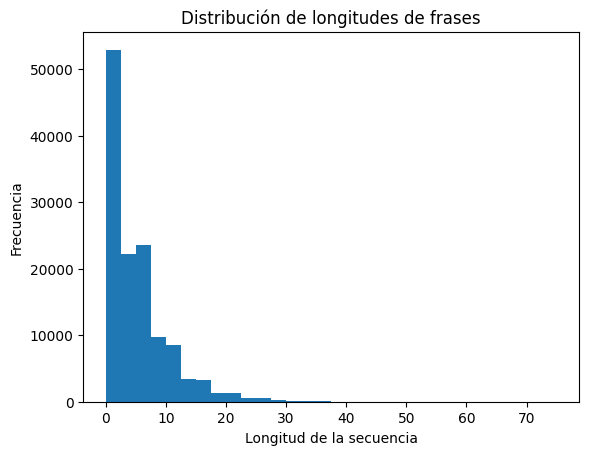

In [ ]:
import matplotlib.pyplot as plt

longitudes = [len(seq) for seq in sequences]
plt.hist(longitudes, bins=30)
plt.xlabel("Longitud de la secuencia")
plt.ylabel("Frecuencia")
plt.title("Distribución de longitudes de frases")
plt.show()


<ipython-input-6-e251a9057595>:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(categorias.keys()), y=list(categorias.values()), palette="coolwarm")


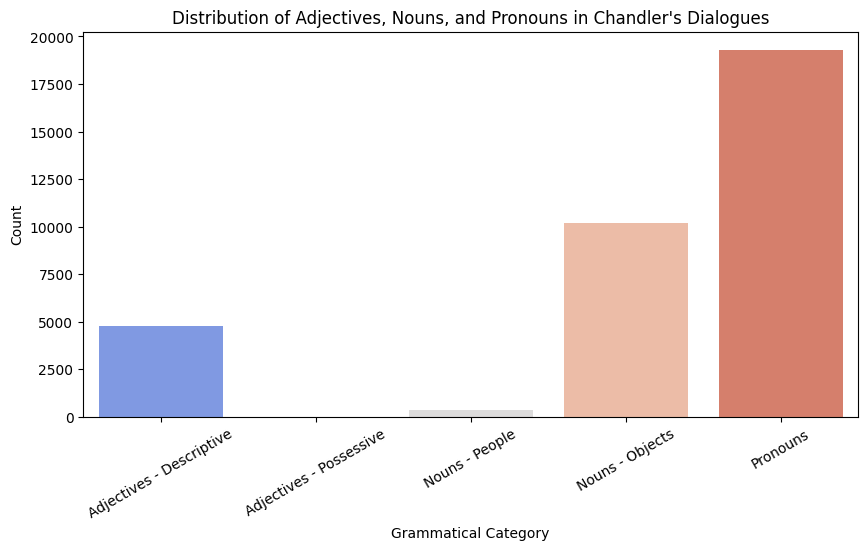

In [ ]:
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Leer el archivo de diálogos de Chandler
with open("/content/dialogos_chandler.txt", "r", encoding="utf-8") as f:
    texto_completo = f.read()

# Cargar el modelo en inglés de spaCy
nlp = spacy.load("en_core_web_sm")

# Procesar el texto con spaCy
doc = nlp(texto_completo)

# Diccionario para contar categorías
categorias = {
    "Adjectives - Descriptive": 0,
    "Adjectives - Possessive": 0,
    "Nouns - People": 0,
    "Nouns - Objects": 0,
    "Pronouns": 0
}

# Palabras clave para clasificación
people_keywords = {"man", "woman", "friend", "boy", "girl", "person", "student", "doctor"}
possessive_adjectives = {"my", "your", "his", "her", "its", "our", "their"}

# Clasificación de palabras
for token in doc:
    if token.pos_ == "ADJ":
        if token.text.lower() in possessive_adjectives:
            categorias["Adjectives - Possessive"] += 1
        else:
            categorias["Adjectives - Descriptive"] += 1
    elif token.pos_ == "NOUN":
        if token.text.lower() in people_keywords:
            categorias["Nouns - People"] += 1
        else:
            categorias["Nouns - Objects"] += 1
    elif token.pos_ == "PRON":
        categorias["Pronouns"] += 1

# Graficar los resultados
plt.figure(figsize=(10, 5))
sns.barplot(x=list(categorias.keys()), y=list(categorias.values()), palette="coolwarm")
plt.ylabel("Count")
plt.xlabel("Grammatical Category")
plt.title("Distribution of Adjectives, Nouns, and Pronouns in Chandler's Dialogues")
plt.xticks(rotation=30)
plt.show()


In [ ]:
print(f"Cantidad de palabras en el tokenizer: {len(tokenizer.word_index)}")


Cantidad de palabras en el tokenizer: 16309


trainning


In [ ]:
# 🔥 `X_train` son las primeras palabras, `y_train` es la siguiente palabra
X_train, y_train = padded_sequences[:, :-1], padded_sequences[:, -1]
#X_train, y_train = padded_sequences, padded_sequences[:, -1]
y_train = np.array(y_train)  # Asegurar que sea un array de NumPy
len(y_train)

128442

creacion del modelo

In [ ]:
# 📌 3. Crear el modelo
input_layer = Input(shape=(max_length-1,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

lstm_1 = LSTM(64, return_sequences=True)(embedding_layer)
lstm_2 = LSTM(64, return_sequences=True)(lstm_1)
lstm_3 = LSTM(256)(lstm_2)

#hidden_layer1 = Dense(256, activation="elu")(lstm_3)
hidden_layer2 = Dense(256, activation="tanh")(lstm_3)
output_layer = Dense(vocab_size, activation="softmax")(hidden_layer2)  # 🔹 Cambiado tamaño de salida

model = Model(inputs=input_layer, outputs=output_layer)
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)  # 🔹 Evitar explosión de gradientes
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 4, 10)               │         170,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 4, 64)               │          19,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 4, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 256)                 │         328,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 17000)               │       4,369,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,985,720 (19.02 MB)

 Trainable params: 4,985,720 (19.02 MB)

 Non-trainable params: 0 (0.00 B)

generar frase

In [ ]:
import numpy as np

def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions + 1e-10) / temperature  # Evita log(0)
    exp_preds = np.exp(predictions)
    probabilities = exp_preds / np.sum(exp_preds)  # Normaliza para obtener una distribución de probabilidad
    return np.random.choice(len(probabilities), p=probabilities)

def generar_texto(frase_inicial, longitud, temperature=1.0):
    for _ in range(longitud):
        # 🔹 Tokenizar la frase inicial usando el mismo tokenizer
        secuencia = tokenizer.texts_to_sequences([frase_inicial])

        # 🔹 Aplicar padding con los mismos parámetros de la tokenización original
        secuencia = pad_sequences(secuencia, maxlen=max_length-1, padding="post")

        # 🔹 Predecir la siguiente palabra
        prediccion = model.predict(secuencia, verbose=0)

        # 🔹 Seleccionar índice con temperatura
        indice_predicho = sample_with_temperature(prediccion[0], temperature)

        # 🔹 Convertir índice a palabra
        palabra_predicha = tokenizer.index_word.get(indice_predicho, "<unk>")

        # 🔹 Si la palabra es <OOV>, evitar agregar ruido
        if palabra_predicha == "<OOV>":
            continue

        # 🔹 Agregar la palabra a la frase inicial
        frase_inicial = frase_inicial.strip() + " " + palabra_predicha

    return frase_inicial


callback

In [ ]:
# 📌 5. Callback para monitorear la generación de texto y memoria
class MonitorEntrenamiento(Callback):
    def on_epoch_end(self, epoch, logs=None):
        frase_prueba = "Hi, how are you?"
        respuesta = generar_texto(frase_prueba, 10)
        memoria = psutil.virtual_memory()
        print(f"\n🔹 Epoch {epoch + 1}: {frase_prueba} → {respuesta}")
        print(f"📌 RAM usada: {memoria.percent}%")


check point y entrenamiento del modelo

In [ ]:
# 📌 6. Entrenar el modelo sin checkpoint
callbacks = [MonitorEntrenamiento()]  # Se elimina checkpoint
history = model.fit(X_train, y_train, epochs=15, batch_size=64, verbose=1, callbacks=callbacks)

# 📌 7. Prueba final de generación
print("\n🔹 Generación final:")
print(generar_texto("Hi, how are you?", 10))


Epoch 1/15
2004/2007 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1636 - loss: 6.3151
🔹 Epoch 1: Hi, how are you? → Hi, how are you? pain sweet bigger ohh it about that boring curiosity gifts
📌 RAM usada: 16.7%
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 28s 11ms/step - accuracy: 0.1636 - loss: 6.3142
Epoch 2/15
2004/2007 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1950 - loss: 5.3251
🔹 Epoch 2: Hi, how are you? → Hi, how are you? doing coming that careful green yet visitors go schiff comes
📌 RAM usada: 16.5%
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.1950 - loss: 5.3250
Epoch 3/15
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2231 - loss: 4.9893
🔹 Epoch 3: Hi, how are you? → Hi, how are you? want any queen real things talk uh this guy on
📌 RAM usada: 16.6%
2007/2007 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - accuracy: 0.2231 - loss: 4.9893
Epoch 4/15
2006/2007 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2423 - loss: 4.7218
🔹 Epoch 4: Hi, how are you? → Hi, how are 

In [ ]:
# 📌 7. Prueba final de generación
print("\n🔹 Generación final:")
print(generar_texto("The world seemed like such a peaceful place until the magic tree was discovered in London.", 1000))


🔹 Generación final:
The world seemed like such a peaceful place until the magic tree was discovered in London. hall today carol i i brought oops there painful people down there too much marriage trees sock bastard you kicked sex luck crazy secrets sorry joey sorry joey young sad sexy channie's movie i could hurt ya piece dear pillow here with us tonight ow dude good doesn't you think about it again monica sorry mike man marriage new proof happen myself too newman you can't go there out around there please err over me man mrs feelings partner ass ski more men anymore y'know what everybody reading married doin' business anymore about me huh mr s yet bobby often are made up either island fantasy clothes thing hunter pageanting yasmine wisdom nirget nice yet myself huh ross strong first man experience red hair impersonal great puppies crazy people worth this afternoon job sign learn ok i can't work inside man okay right again tonight uh before that stuff again gone for them mrs man day ow

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Suponiendo que ya tenés un tokenizer entrenado

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(frases)
# Tokenizar las frases
secuencias = tokenizer.texts_to_sequences(frases)

# Mostrar las primeras secuencias
print("Ejemplo de secuencias tokenizadas:", secuencias[:5])

# Padding para asegurar que todas las secuencias tengan la misma longitud
input_sequence = pad_sequences(secuencias, maxlen=20, padding='post')  # Ajustar maxlen según tu modelo

print("Forma de input_sequence:", input_sequence.shape)
print("Ejemplo de input_sequence:", input_sequence[:5])


Ejemplo de secuencias tokenizadas: [[41, 44, 88, 40, 175], [25, 176, 70, 29, 7, 1643], [7, 1643, 8, 7, 3012], [384, 49, 7, 347, 6, 18], [196, 25, 12, 17, 112, 23, 475, 561, 12, 17, 846, 23, 4, 792, 21, 4, 3013, 8, 2, 736, 2, 126, 283, 394]]
Forma de input_sequence: (14344, 20)
Ejemplo de input_sequence: [[  41   44   88   40  175    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  25  176   70   29    7 1643    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   7 1643    8    7 3012    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 384   49    7  347    6   18    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 112   23  475  561   12   17  846   23    4  792   21    4 3013    8
     2  736    2  126  283  394]]


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Inicializar el Tokenizer y entrenarlo con el texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(frases)  # Aprender el vocabulario de las frases

# Convertir las frases en secuencias numéricas
secuencias = tokenizer.texts_to_sequences(frases)

# Verificar si ahora las secuencias tienen contenido
print("Ejemplo de secuencias tokenizadas:", secuencias[:5])

# Aplicar padding para normalizar las longitudes
input_sequence = pad_sequences(secuencias, maxlen=20, padding='post')

print("Forma de input_sequence:", input_sequence.shape)
print("Ejemplo de input_sequence:", input_sequence[:5])


Ejemplo de secuencias tokenizadas: [[35, 37, 82, 34, 159], [25, 160, 42, 22, 7, 1628], [7, 1628, 10, 7, 2998], [363, 44, 7, 326, 6, 18], [178, 25, 1, 17, 102, 23, 454, 544, 1, 17, 828, 23, 4, 774, 21, 4, 2999, 10, 1, 718, 1, 17, 265, 373]]
Forma de input_sequence: (14344, 20)
Ejemplo de input_sequence: [[  35   37   82   34  159    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [  25  160   42   22    7 1628    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [   7 1628   10    7 2998    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 363   44    7  326    6   18    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]
 [ 102   23  454  544    1   17  828   23    4  774   21    4 2999   10
     1  718    1   17  265  373]]


In [ ]:
import numpy as np

# Verificar la forma de input_sequence
print("Forma de input_sequence:", input_sequence.shape)

# Hacer la predicción con el modelo
predicted_indices = model.predict(input_sequence)

# Obtener los índices con mayor probabilidad
predicted_indices = np.argmax(predicted_indices, axis=-1)

print("Índices predichos:", predicted_indices[:5])  # Mostrar los primeros 5 resultados


Forma de input_sequence: (14344, 20)
449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Índices predichos: [0 0 0 0 0]


In [ ]:
# Verificar si la salida del modelo tiene valores significativos
predicciones = model.predict(input_sequence)
print("Ejemplo de salida del modelo:", predicciones[:5])  # Muestra las primeras 5 filas
print("Máximo valor en predicciones:", np.max(predicciones))
print("Mínimo valor en predicciones:", np.min(predicciones))


449/449 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Ejemplo de salida del modelo: [[7.8388977e-01 1.8722613e-08 2.5012137e-04 ... 1.6860712e-08
  1.8234948e-08 1.5207766e-08]
 [7.8388977e-01 1.8722647e-08 2.5012137e-04 ... 1.6860712e-08
  1.8234948e-08 1.5207766e-08]
 [7.8388983e-01 1.8722615e-08 2.5012140e-04 ... 1.6860714e-08
  1.8234950e-08 1.5207767e-08]
 [7.8388983e-01 1.8722615e-08 2.5012140e-04 ... 1.6860714e-08
  1.8234950e-08 1.5207767e-08]
 [7.8388977e-01 1.8722613e-08 2.5012137e-04 ... 1.6860712e-08
  1.8234948e-08 1.5207766e-08]]
Máximo valor en predicciones: 0.7838899
Mínimo valor en predicciones: 1.1469377e-08


In [ ]:
import numpy as np
pred_classes = np.argmax(predicciones, axis=-1)
unique, counts = np.unique(pred_classes, return_counts=True)
print("Distribución de clases predichas:", dict(zip(unique, counts)))


Distribución de clases predichas: {np.int64(0): np.int64(14344)}


In [ ]:
import collections
print(collections.Counter([seq[-1] for seq in input_sequence]))  # Último token como etiqueta


Counter({np.int32(0): 13885, np.int32(2): 11, np.int32(5): 10, np.int32(18): 7, np.int32(47): 6, np.int32(199): 6, np.int32(11): 6, np.int32(15): 5, np.int32(219): 5, np.int32(83): 5, np.int32(66): 5, np.int32(109): 5, np.int32(204): 4, np.int32(87): 4, np.int32(102): 4, np.int32(334): 4, np.int32(31): 4, np.int32(202): 4, np.int32(49): 4, np.int32(10): 3, np.int32(158): 3, np.int32(425): 3, np.int32(442): 3, np.int32(162): 3, np.int32(92): 3, np.int32(239): 3, np.int32(170): 3, np.int32(269): 3, np.int32(330): 3, np.int32(8): 3, np.int32(34): 3, np.int32(242): 3, np.int32(74): 3, np.int32(373): 2, np.int32(3): 2, np.int32(2166): 2, np.int32(1391): 2, np.int32(795): 2, np.int32(355): 2, np.int32(251): 2, np.int32(1445): 2, np.int32(281): 2, np.int32(59): 2, np.int32(220): 2, np.int32(1800): 2, np.int32(147): 2, np.int32(2374): 2, np.int32(65): 2, np.int32(6): 2, np.int32(52): 2, np.int32(141): 2, np.int32(142): 2, np.int32(55): 2, np.int32(48): 2, np.int32(300): 2, np.int32(104): 2, np

In [ ]:
print("Ejemplo de secuencias:", sequences[:5])
print("Ejemplo de secuencias con padding:", padded_sequences[:5])


In [ ]:
print("Ejemplo de X_train:", X_train[:5])
print("Ejemplo de y_train:", y_train[:5])


In [ ]:
print(tokenizer.word_index)


{'<OOV>': 1, 'i': 2, 'you': 3, 'the': 4, 'to': 5, 'a': 6, 'and': 7, 'that': 8, 'it': 9, 'no': 10, 'what': 11, 'is': 12, 'me': 13, "i'm": 14, 'oh': 15, 'this': 16, 'of': 17, 'we': 18, 'in': 19, 'okay': 20, 'so': 21, 'my': 22, 'just': 23, 'have': 24, 'not': 25, 'do': 26, 'well': 27, 'know': 28, "don't": 29, 'was': 30, "it's": 31, 'yeah': 32, 'with': 33, 'hey': 34, 'for': 35, 'be': 36, 'all': 37, 'are': 38, 'on': 39, 'right': 40, 'but': 41, 'get': 42, "that's": 43, 'like': 44, 'your': 45, 'gonna': 46, 'out': 47, 'her': 48, 'if': 49, 'can': 50, 'go': 51, 'think': 52, 'about': 53, "you're": 54, "y'know": 55, 'here': 56, 'look': 57, 'up': 58, 'uh': 59, 'she': 60, 'there': 61, 'at': 62, 'really': 63, 'he': 64, 'yes': 65, 'now': 66, 'did': 67, 'one': 68, 'see': 69, 'why': 70, 'got': 71, 'how': 72, 'mean': 73, 'good': 74, 'because': 75, 'when': 76, "we're": 77, "can't": 78, 'say': 79, 'want': 80, 'going': 81, 'joey': 82, 'would': 83, 'him': 84, 'then': 85, 'come': 86, 'they': 87, 'time': 88, "d

In [ ]:
print(tokenizer.texts_to_sequences(["a hump and a hairpiece?"]))


[[14, 25, 90, 62, 4]]


In [ ]:
print(tokenizer.word_index.get("m"))  # Ver si existe en el diccionario



1567


In [ ]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
from keras_tuner.tuners import Hyperband

# 📌 1. Definir hiperparámetros globales
vocab_size = 25000  # Número máximo de palabras en el vocabulario
max_length = 10  # Longitud máxima de la secuencia



# 📌 3. Tokenización y preprocesamiento
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(frases)

sequences = tokenizer.texts_to_sequences(frases)
padded_sequences = pad_sequences(sequences, maxlen=max_length-1, padding="post")

# 🔥 `X_train` son las primeras palabras, `y_train` es la última palabra de cada secuencia
X_train, y_train = padded_sequences[:, :-1], padded_sequences[:, -1]
y_train = np.array(y_train)  # Asegurar que sea un array de NumPy

# 📌 4. Función para construir el modelo
def build_model(hp):
    input_layer = Input(shape=(max_length - 1,))

    # Hiperparámetro: Dimensión del embedding
    embedding_dim = hp.Choice("embedding_dim", [10, 50, 100])
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim)(input_layer)

    # Hiperparámetro: Número de unidades en LSTM
    lstm_units = hp.Choice("lstm_units", [64, 128, 256])
    lstm_layer = LSTM(lstm_units, return_sequences=False)(embedding_layer)

    hidden_layer = Dense(128, activation="tanh")(lstm_layer)

    output_layer = Dense(vocab_size, activation="softmax")(hidden_layer)

    # Hiperparámetro: Tasa de aprendizaje
    learning_rate = hp.Choice("learning_rate", [0.01, 0.001, 0.0001])
    optimizer = Adam(learning_rate=learning_rate, clipvalue=1.0)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

# 📌 5. Configurar el tuner
tuner = Hyperband(
    build_model,
    objective="accuracy",  # Maximizar la precisión
    max_epochs=10,  # Máximo de épocas a entrenar
    factor=3,  # Factor de reducción en Hyperband
    directory="kerastuner_results",  # Carpeta donde guarda resultados
    project_name="lstm_tuning"
)

# 📌 6. Ejecutar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# 📌 7. Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Mejor configuración encontrada:")
print(f"- embedding_dim: {best_hps.get('embedding_dim')}")
print(f"- lstm_units: {best_hps.get('lstm_units')}")
print(f"- learning_rate: {best_hps.get('learning_rate')}")


Trial 30 Complete [00h 00m 27s]
accuracy: 0.7789106965065002

Best accuracy So Far: 0.8047058582305908
Total elapsed time: 00h 06m 42s
Mejor configuración encontrada:
- embedding_dim: 50
- lstm_units: 64
- learning_rate: 0.01
